# Create Q&A Dataset

In this task, we create the Q&A dataset by parsing each body text to find a question sentence, an answer sentence, and a context.

Assumptions:

1. The sentence following the question sentence is the answer.
2. To mimic popular Q&A datasets, we also need to input a starting index, and a context. See figure that follows.
3. The context is defined as the sentences before a questions if it exists, and the sentences after the question. Including the answer sentence. The choices for how many sentances to take in from before or after a question is arbitrary.

The format we are going for is shown below:

<img src="squad_format.png"></img>
<center>Figure 1. A snippert of the SQuAD dataset</center>

In [15]:
from glob import glob
from tqdm import tqdm
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from nltk import tokenize
import uuid

In [13]:
def filter_json(source_dir, dest_dir):
    """Discards json files with no body text"""
    files = glob(os.path.join(source_dir, '*.json'))
    for file in tqdm(files):
        with open(file) as f:
            data = json.load(f)
            
        if data['body']:
            filename = file.split('/')[-1]
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)
            save_path = os.path.join(dest_dir, filename)
            with open(save_path, 'w') as f:
                json.dump(data, f)

In [14]:
source_dir = '../magazines'
dest_dir = '../data/filtered/magazines'
filter_json(source_dir, dest_dir)

100%|██████████| 9978/9978 [00:18<00:00, 552.84it/s]


In [ ]:
# use filtered dataset for faster read-write time

In [1]:
!pwd

/home/mdorosan/2022/addiction_chatbot/qa_pipeline


In [16]:
def eda(source_dir):
    """Return array of counts of number of pars, and word per par"""
    files = glob(os.path.join(source_dir, '*.json'))
    num_paragraphs = []
    words_per_paragraph = []
    for file in tqdm(files):
        with open(file) as f:
            data = json.load(f)
        num_paragraphs.append(len(data['body'].split('\n')))
        for par in data['body'].split('\n'):
            words_per_paragraph.append(len(par.split(' ')))
    return num_paragraphs, words_per_paragraph

In [17]:
source_dir = '../data/filtered/*'
num_paragraphs, words_per_paragraph = eda(source_dir)

100%|██████████| 17929/17929 [00:11<00:00, 1531.54it/s]


No. paragraphs, min 1 max 310 median 22.0
No. words per par, min 1 max 229 median 46.0


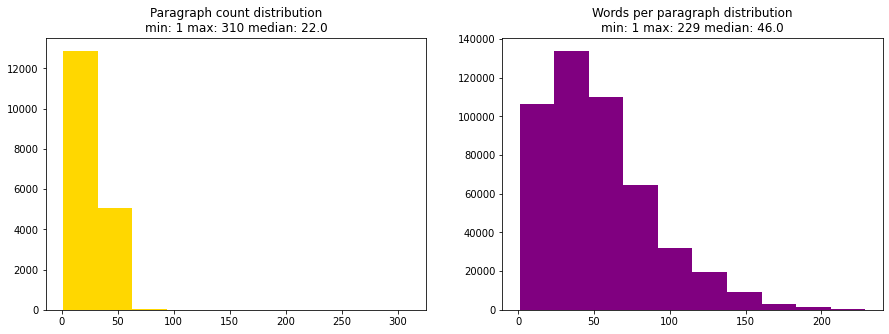

In [18]:
min_p = np.min(num_paragraphs)
max_p = np.max(num_paragraphs)
med_p = np.median(num_paragraphs)

min_w = np.min(words_per_paragraph)
max_w = np.max(words_per_paragraph)
med_w = np.median(words_per_paragraph)
print(f"No. paragraphs, min {min_p} max {max_p} median {med_p}")
print(f"No. words per par, min {min_w} max {max_w} median {med_w}")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(num_paragraphs, color='gold')
ax[1].hist(words_per_paragraph, color='purple')

ax[0].set_title(f'Paragraph count distribution\nmin: {min_p} max: {max_p} median: {med_p}')
ax[1].set_title(f'Words per paragraph distribution\nmin: {min_w} max: {max_w} median: {med_w}')
plt.show()

In [19]:
def get_sentence_counts(source_dir):
    files = glob(os.path.join(source_dir, '*.json'))
    sentence_counts = []
    for file in tqdm(files):
        with open(file) as f:
            data = json.load(f)
        paragraphs = data['body'].split('\n')
        for paragraph in paragraphs:
            count = len(tokenize.sent_tokenize(paragraph))
            sentence_counts.append(count)
    return sentence_counts

source_dir = '../data/filtered/*'
sentence_counts = get_sentence_counts(source_dir)

100%|██████████| 17929/17929 [00:53<00:00, 333.01it/s]


No. sentences, min 1 max 16 median 3.0


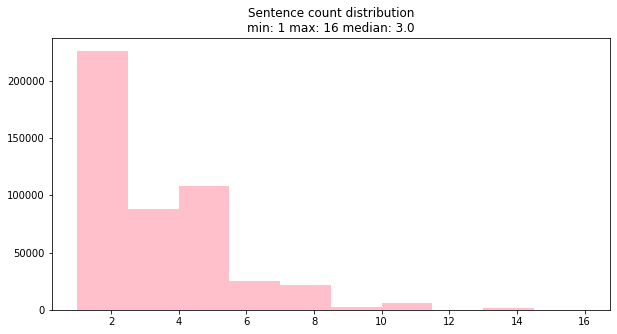

In [20]:
# eda
min_s = np.min(sentence_counts)
max_s = np.max(sentence_counts)
med_s = np.median(sentence_counts)

print(f"No. sentences, min {min_s} max {max_s} median {med_s}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist(sentence_counts, color='pink')

ax.set_title(f'Sentence count distribution\nmin: {min_s} max: {max_s} median: {med_s}')
plt.show()

In [21]:
source_dir = '../data/filtered/general-conference'
files = glob(os.path.join(source_dir, '*.json')) 
with open(files[0]) as f:
    data = json.load(f)
data.keys()

dict_keys(['page', 'index', 'title', 'kicker', 'body', 'author', 'calling', 'url'])

In [22]:
def extract_qa(source_dir, dest_dir, context_size=5, answer_size=1):
    """Create dataset to the flavor of SQuAD"""
    files = glob(os.path.join(source_dir, '*.json'))
    for file in tqdm(files):
        with open(file) as f:
            data = json.load(f)
        
        paragraphs = data['body'].split('\n')
        sentences = []
        for paragraph in paragraphs:
            sentences.extend(tokenize.sent_tokenize(paragraph))
        question_indices = []
        for index, sentence in enumerate(sentences):
            if sentence.endswith('?'):
                question_indices.append(index)
        s_length = len(sentences)
        for q in question_indices:
            qa_data = {k:v for k,v in data.items() if k not \
                       in ['kicker', 'body', 'author', 'calling', 'url']}    
            
            # right context
            if q + answer_size >= len(sentences): # last sentence of the body
                continue
            elif q + 5 < len(sentences):
                context_right = ' '.join(sentences[q + 1: q + 6])
            else:
                # sentence after, then onwards
                context_right = ' '.join(sentences[q + 1: ])
            
            # left context
            if q == 0:
                context_left = None
            elif q - 5 >= 0:
                context_left = ' '.join(sentences[q - 5: q])
            else:
                context_left = ' '.join(sentences[0: q])
            
            
            # build context
            if bool(context_left):
                context = context_left + ' ' + context_right
                answer_start = len(context_left) + 1
            else:
                context = context_right
                answer_start = len(sentences[q])
            
            # build qa_data
            qa_data['context'] = context
            qa_data['question'] = sentences[q]
            
            # get answer indices : the next answer_size sentences to the question
            answer_index = [q + 1]
            while answer_index[-1] != q + answer_size:
                answer_index.append(answer_index[-1] + 1)
            answer_list = list(np.array(sentences)[answer_index])
            if len(answer_list) > 1:
                text = ' '.join(answer_list)
            else:
                text = answer_list[0]
            answers = {
                'answer_start': [answer_start],
                'text': [text]
            }
            qa_data['answers'] = answers
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)
            new_filename = str(uuid.uuid4()) + '.json'    
            save_path = os.path.join(dest_dir, new_filename)
            with open(save_path, 'w') as f:
                json.dump(qa_data, f)      

In [30]:
answer_size = 3
source_dir = '../data/filtered/general-conference'
dest_dir = f'../data/qa-{answer_size}/general-conference'
extract_qa(source_dir, dest_dir, answer_size=answer_size)

100%|██████████| 7968/7968 [01:22<00:00, 96.93it/s] 


In [28]:
len(glob(f'../data/qa-{answer_size}/general-conference/*.json'))

19028

## End